In [2]:
import numpy as np, pandas as pd, scanpy as sc, matplotlib.pyplot as plt, os
from scipy.stats import hypergeom
import celloracle as co, glob, pickle
from functools import reduce
from tqdm import tqdm
import itertools, math, random
import networkx as nx
from itertools import combinations
from scipy.stats import gmean

# visualization settings required to see plots in jupyter notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

wd = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/cicero_outs'
out_path = os.path.join(wd, 'out_data')
os.makedirs(f"{out_path}/figures", exist_ok=True)
os.makedirs(f"{out_path}/out_files", exist_ok=True)
sc.settings.figdir = f"{out_path}/figures"
random.seed(42)

In [2]:
!which bedtools

/opt/packages/bedtools/2.30.0/bedtools


# TF-Target activity as calculated by binding score across 40-50 bp regions

### Using the regions where the TF is bound and within +- 500kb of a target TSS

In [14]:
input_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files'
pseudotime_values_of_windows = pd.read_csv(os.path.join(input_folder, 'pseudotime_values_of_windows.csv'), header=None)[0].tolist()
# assign window indices to bifurcation branches
PB_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(98, 147, 1)) + [2]
GC_fate_window_indices = [1] + list(range(97, 3, -1)) + [0] + list(range(147, 193, 1)) + [3]
PB_post_bifurcation_window_indices = [0] + list(range(98, 147, 1)) + [2]
GC_post_bifurcation_window_indices = [0] + list(range(147, 193, 1)) + [3]

In [7]:
import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
import os
from tqdm import tqdm
import glob

def extract_tf_target_link(linking_file, tf_name, target_name):
    """
    Extract a specific TF-target linking value from a single linking file.
    
    Parameters:
    -----------
    linking_file : str
        Path to the linking.tsv.gz file
    tf_name : str
        Name of the transcription factor
    target_name : str
        Name of the target gene
    
    Returns:
    --------
    tuple : (subset_number, linking_value)
    """
    try:
        # Read the linking file
        linking_df = pd.read_csv(linking_file, header=0, index_col=0, sep='\t', compression='gzip')
        
        # Extract subset number from file path
        subset_num = int(linking_file.split('Subset')[-1].split('/')[0])
        
        # Check if TF and target exist in the DataFrame
        if tf_name in linking_df.index and target_name in linking_df.columns:
            linking_value = linking_df.loc[tf_name, target_name]
            return (subset_num, linking_value)
        else:
            # Return None if TF or target not found
            return (subset_num, np.nan)
            
    except Exception as e:
        print(f"Error processing {linking_file}: {str(e)}")
        subset_num = int(linking_file.split('Subset')[-1].split('/')[0])
        return (subset_num, np.nan)

def extract_multiple_tf_target_links(linking_file, tf_target_pairs):
    """
    Extract multiple TF-target linking values from a single linking file.
    
    Parameters:
    -----------
    linking_file : str
        Path to the linking.tsv.gz file
    tf_target_pairs : list
        List of tuples containing (tf_name, target_name) pairs
    
    Returns:
    --------
    dict : Dictionary with subset number as key and linking values as values
    """
    try:
        # Read the linking file
        linking_df = pd.read_csv(linking_file, header=0, index_col=0, sep='\t', compression='gzip')
        
        # Extract subset number from file path
        subset_num = int(linking_file.split('Subset')[-1].split('/')[0])
        
        results = {}
        for tf_name, target_name in tf_target_pairs:
            if tf_name in linking_df.index and target_name in linking_df.columns:
                linking_value = linking_df.loc[tf_name, target_name]
                results[f"{tf_name}_{target_name}"] = linking_value
            else:
                results[f"{tf_name}_{target_name}"] = np.nan
                
        return {subset_num: results}
        
    except Exception as e:
        print(f"Error processing {linking_file}: {str(e)}")
        subset_num = int(linking_file.split('Subset')[-1].split('/')[0])
        return {subset_num: {f"{tf}_{target}": np.nan for tf, target in tf_target_pairs}}

def get_linking_files(base_path):
    """
    Get all linking.tsv.gz files from the base path.
    
    Parameters:
    -----------
    base_path : str
        Base path containing Subset directories
    
    Returns:
    --------
    list : List of file paths
    """
    pattern = os.path.join(base_path, "Subset*/linking.tsv.gz")
    linking_files = glob.glob(pattern)
    linking_files.sort(key=lambda x: int(x.split('Subset')[-1].split('/')[0]))
    return linking_files

def extract_tf_target_across_subsets(base_path, tf_name, target_name, n_jobs=-1):
    """
    Extract a specific TF-target linking value across all subsets using parallel processing.
    
    Parameters:
    -----------
    base_path : str
        Base path containing Subset directories
    tf_name : str
        Name of the transcription factor
    target_name : str
        Name of the target gene
    n_jobs : int
        Number of parallel jobs (-1 for all available cores)
    
    Returns:
    --------
    pd.DataFrame : DataFrame with TF-Target as index and subsets as columns
    """
    linking_files = get_linking_files(base_path)
    
    if n_jobs == -1:
        n_jobs = os.cpu_count()
    
    results = {}
    
    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        # Submit all jobs
        future_to_file = {
            executor.submit(extract_tf_target_link, file_path, tf_name, target_name): file_path 
            for file_path in linking_files
        }
        
        # Collect results with progress bar
        for future in tqdm(as_completed(future_to_file), total=len(linking_files), desc="Processing subsets"):
            subset_num, linking_value = future.result()
            results[subset_num] = linking_value
    
    # Create DataFrame
    df = pd.DataFrame({
        'Subset': list(results.keys()),
        'Linking_Value': list(results.values())
    }).set_index('Subset').T
    
    # Set index name
    df.index = [f"{tf_name}_{target_name}"]
    
    return df

def extract_multiple_tf_targets_across_subsets(base_path, tf_target_pairs, n_jobs=-1):
    """
    Extract multiple TF-target linking values across all subsets using parallel processing.
    
    Parameters:
    -----------
    base_path : str
        Base path containing Subset directories
    tf_target_pairs : list
        List of tuples containing (tf_name, target_name) pairs
    n_jobs : int
        Number of parallel jobs (-1 for all available cores)
    
    Returns:
    --------
    pd.DataFrame : DataFrame with TF-Target pairs as index and subsets as columns
    """
    linking_files = get_linking_files(base_path)
    
    if n_jobs == -1:
        n_jobs = os.cpu_count()
    
    all_results = {}
    
    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        # Submit all jobs
        future_to_file = {
            executor.submit(extract_multiple_tf_target_links, file_path, tf_target_pairs): file_path 
            for file_path in linking_files
        }
        
        # Collect results with progress bar
        for future in tqdm(as_completed(future_to_file), total=len(linking_files), desc="Processing subsets"):
            subset_results = future.result()
            all_results.update(subset_results)
    
    # Create DataFrame
    df_data = {}
    for tf, target in tf_target_pairs:
        tf_target_key = f"{tf}_{target}"
        df_data[tf_target_key] = []
        for subset_num in sorted(all_results.keys()):
            df_data[tf_target_key].append(all_results[subset_num].get(tf_target_key, np.nan))
    
    df = pd.DataFrame(df_data, index=sorted(all_results.keys()))
    df.index.name = 'Subset'
    
    return df.T

# Example usage for your specific case
def main():
    # Base path to your data
    base_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/tmp_dynamic'
    
    # Extract single TF-target link
    print("Extracting MYC-LMAN1 link across all subsets...")
    myc_lman1_df = extract_tf_target_across_subsets(
        base_path=base_path,
        tf_name='MYC',
        target_name='LMAN1',
        n_jobs=-1  # Use all available cores
    )
    
    print("MYC-LMAN1 linking values across subsets:")
    print(myc_lman1_df)
    
    # Extract multiple TF-target links
    print("\nExtracting multiple TF-target links...")
    tf_target_pairs = [
        ('MYC', 'LMAN1'),
        ('PAX5', 'CD19'),
        ('IRF4', 'PRDM1')
    ]
    
    multiple_links_df = extract_multiple_tf_targets_across_subsets(
        base_path=base_path,
        tf_target_pairs=tf_target_pairs,
        n_jobs=-1
    )
    
    print("Multiple TF-target linking values across subsets:")
    print(multiple_links_df)
    
    # Save results
    myc_lman1_df.to_csv('myc_lman1_linking_values.csv')
    multiple_links_df.to_csv('multiple_tf_target_linking_values.csv')
    
    return myc_lman1_df, multiple_links_df

if __name__ == "__main__":
    myc_lman1_df, multiple_links_df = main()

Extracting MYC-LMAN1 link across all subsets...


Processing subsets: 100%|██████████| 194/194 [00:13<00:00, 14.56it/s]


MYC-LMAN1 linking values across subsets:
Subset          2         3         4         1         10        9    \
MYC_LMAN1  5.693862  5.056324  5.193904  4.979364  5.760378  5.686769   

Subset          8         5         12        11   ...      173  187  190  \
MYC_LMAN1  5.493917  4.692109  6.074075  5.875534  ...  5.34099 -inf -inf   

Subset          168       172       192       191       189      194       193  
MYC_LMAN1  5.199902  5.340254  4.545053  4.688154  4.938335  5.09535  4.505847  

[1 rows x 194 columns]

Extracting multiple TF-target links...


Processing subsets: 100%|██████████| 194/194 [00:13<00:00, 14.72it/s]


Multiple TF-target linking values across subsets:
Subset           1         2         3         4         5         6    \
MYC_LMAN1   4.979364  5.693862  5.056324  5.193904  4.692109  5.062859   
PAX5_CD19       -inf      -inf      -inf      -inf      -inf      -inf   
IRF4_PRDM1      -inf      -inf  5.233862      -inf      -inf      -inf   

Subset           7         8         9         10   ...       185       186  \
MYC_LMAN1   5.350549  5.493917  5.686769  5.760378  ...  4.991483  4.937729   
PAX5_CD19       -inf      -inf      -inf      -inf  ...  3.914982  3.750501   
IRF4_PRDM1      -inf      -inf      -inf      -inf  ...      -inf      -inf   

Subset           187  188       189  190       191       192       193  \
MYC_LMAN1       -inf -inf  4.938335 -inf  4.688154  4.545053  4.505847   
PAX5_CD19   3.599713 -inf      -inf -inf      -inf      -inf      -inf   
IRF4_PRDM1      -inf -inf      -inf -inf      -inf      -inf      -inf   

Subset          194  
MYC_LMAN1   5.095

In [16]:
display(myc_lman1_df)

Subset,2,3,4,1,10,9,8,5,12,11,...,173,187,190,168,172,192,191,189,194,193
MYC_LMAN1,5.693862,5.056324,5.193904,4.979364,5.760378,5.686769,5.493917,4.692109,6.074075,5.875534,...,5.34099,-inf,-inf,5.199902,5.340254,4.545053,4.688154,4.938335,5.09535,4.505847


Available columns (sorted): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194]
Requested indices: [0, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115

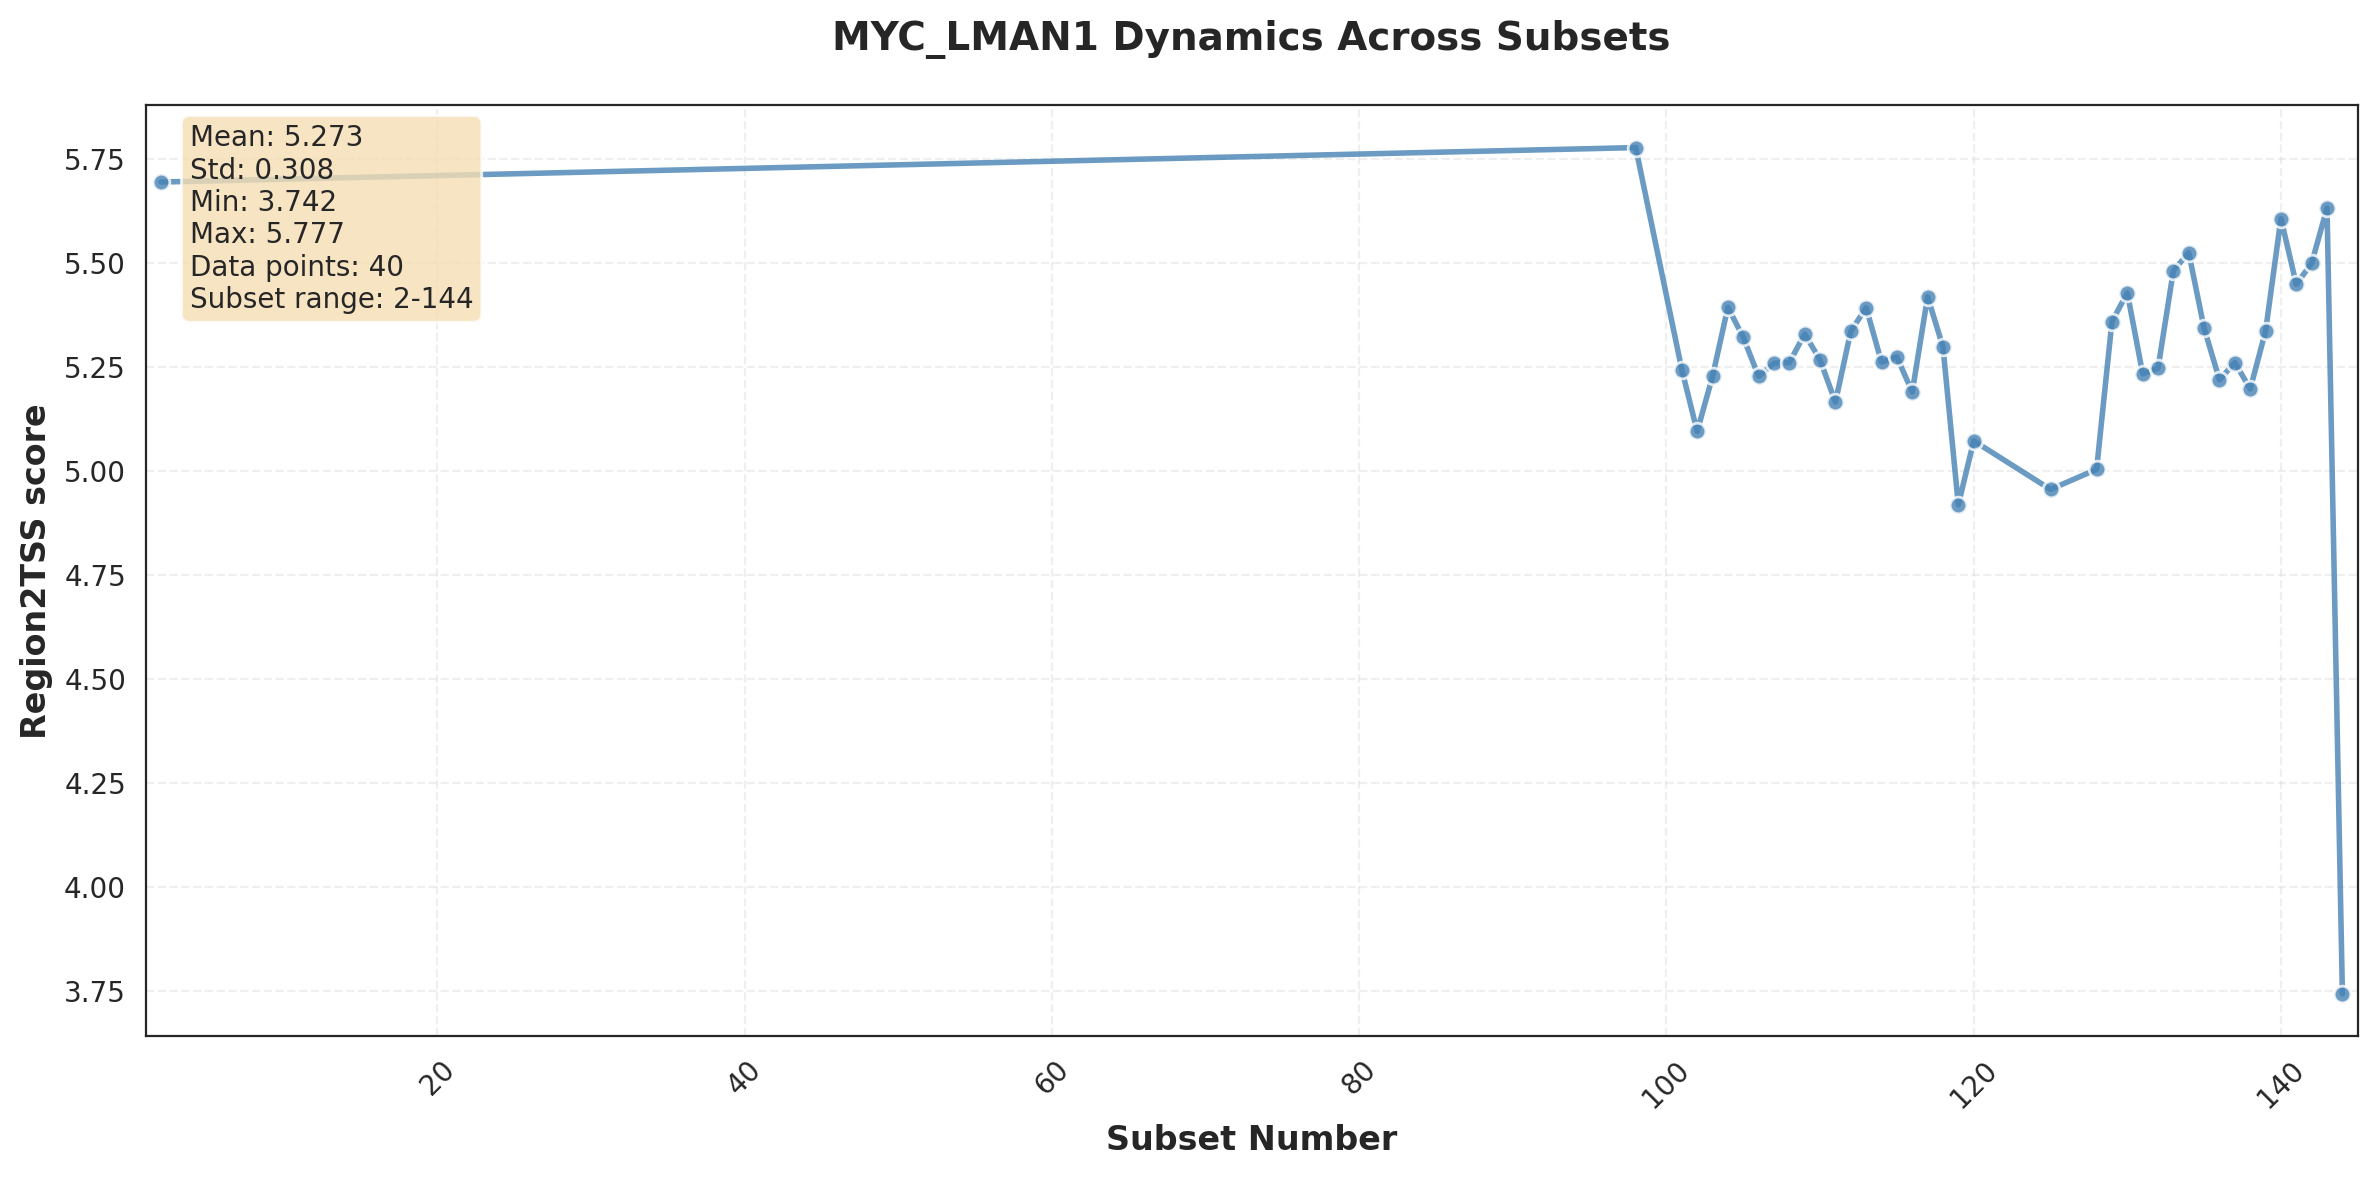

Analysis of MYC_LMAN1 dynamics:
mean: 5.272851120934627
std: 0.308369193805333
min: 3.742385349438341
max: 5.776640616202555
median: 5.269626183904975
n_data_points: 40
n_total_points: 50
n_inf_points: 10
n_nan_points: 0
subset_range: 2-144
trend_slope: -0.0031416660627095337
trend_intercept: 5.6456883409266805
trend_r_squared: 0.05746744951096931
trend_p_value: 0.1362530044426341


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def sort_dataframe_columns(df):
    """
    Sort DataFrame columns by subset number.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with subset numbers as column names
    
    Returns:
    --------
    pd.DataFrame : DataFrame with sorted columns
    """
    # Convert column names to integers for proper sorting
    numeric_columns = pd.to_numeric(df.columns, errors='coerce')
    
    # Create a mapping of original column names to numeric values
    column_mapping = dict(zip(df.columns, numeric_columns))
    
    # Sort columns by their numeric values
    sorted_columns = sorted(df.columns, key=lambda x: column_mapping[x])
    
    # Return DataFrame with sorted columns
    return df[sorted_columns]

def clean_and_plot_tf_target_dynamics(df, window_indices, tf_target_pair, figsize=(12, 6), 
                                    remove_inf=True, plot_style='line', 
                                    color='steelblue', alpha=0.8, 
                                    linewidth=2, marker='o', markersize=6):
    """
    Clean and plot TF-target linking dynamics across subsets.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with TF-Target as index and subsets as columns
    window_indices : list
        List of window indices to plot
    tf_target_pair : str
        TF-Target pair to plot (e.g., 'MYC_LMAN1')
    figsize : tuple
        Figure size (width, height)
    remove_inf : bool
        Whether to remove -inf values (treat as missing data)
    plot_style : str
        Plot style ('line', 'scatter', 'both')
    color : str
        Color for the plot
    alpha : float
        Transparency of the plot
    linewidth : int
        Width of the line
    marker : str
        Marker style for points
    markersize : int
        Size of markers
    
    Returns:
    --------
    tuple : (cleaned_data, fig, ax)
    """
    # First, sort the DataFrame columns
    df_sorted = sort_dataframe_columns(df)
    
    # Filter to only include existing columns (no string conversion needed)
    available_columns = set(df_sorted.columns)
    valid_indices = [idx for idx in window_indices if idx in available_columns]
    
    if not valid_indices:
        raise ValueError(f"None of the window indices {window_indices} exist in the DataFrame columns: {list(df_sorted.columns)}")
    
    print(f"Available columns (sorted): {list(df_sorted.columns)}")
    print(f"Requested indices: {window_indices}")
    print(f"Valid indices found: {valid_indices}")
    print(f"Missing indices: {[idx for idx in window_indices if idx not in available_columns]}")
    
    # subset the data to the valid window indices as columns
    df_subset = df_sorted.loc[:, valid_indices]
    
    # Extract the data for the specific TF-target pair
    if tf_target_pair in df_subset.index:
        data = df_subset.loc[tf_target_pair]
    else:
        raise ValueError(f"TF-Target pair '{tf_target_pair}' not found in DataFrame")
    
    # Convert to numeric, handling any non-numeric values
    data_numeric = pd.to_numeric(data, errors='coerce')
    
    # Create a DataFrame with actual subset numbers and values
    plot_df = pd.DataFrame({
        'Window': data_numeric.index,  # Use actual column names (subset numbers)
        'Region2TSS score': data_numeric.values
    }).sort_values('Window')
    
    # Remove -inf values if requested
    if remove_inf:
        plot_df = plot_df[plot_df['Region2TSS score'] != -np.inf]
        plot_df = plot_df[plot_df['Region2TSS score'].notna()]  # Also remove NaN values
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    if plot_style == 'line':
        ax.plot(plot_df['Window'], plot_df['Region2TSS score'], 
                color=color, alpha=alpha, linewidth=linewidth, 
                marker=marker, markersize=markersize, 
                markerfacecolor=color, markeredgecolor='white', 
                markeredgewidth=1)
    elif plot_style == 'scatter':
        ax.scatter(plot_df['Window'], plot_df['Region2TSS score'], 
                   color=color, alpha=alpha, s=markersize*20)
    elif plot_style == 'both':
        ax.plot(plot_df['Window'], plot_df['Region2TSS score'], 
                color=color, alpha=alpha, linewidth=linewidth)
        ax.scatter(plot_df['Window'], plot_df['Region2TSS score'], 
                   color=color, alpha=alpha, s=markersize*20)
    
    # Customize the plot
    ax.set_xlabel('Subset Number', fontsize=12, fontweight='bold')
    ax.set_ylabel('Region2TSS score', fontsize=12, fontweight='bold')
    ax.set_title(f'{tf_target_pair} Dynamics Across Subsets', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Set x-axis limits to show the actual range of subset numbers
    ax.set_xlim(plot_df['Window'].min() - 1, plot_df['Window'].max() + 1)
    
    # Rotate x-axis labels if there are many subsets
    if len(plot_df) > 20:
        plt.xticks(rotation=45)
    
    # Add statistics
    stats_text = f"Mean: {plot_df['Region2TSS score'].mean():.3f}\n"
    stats_text += f"Std: {plot_df['Region2TSS score'].std():.3f}\n"
    stats_text += f"Min: {plot_df['Region2TSS score'].min():.3f}\n"
    stats_text += f"Max: {plot_df['Region2TSS score'].max():.3f}\n"
    stats_text += f"Data points: {len(plot_df)}\n"
    stats_text += f"Subset range: {plot_df['Window'].min()}-{plot_df['Window'].max()}"
    
    # Add text box with statistics
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', 
            facecolor='wheat', alpha=0.8), fontsize=10)
    
    plt.tight_layout()
    
    return plot_df, fig, ax

def plot_multiple_tf_targets(df, window_indices, tf_target_pairs, figsize=(15, 10), 
                           remove_inf=True, colors=None, 
                           subplot_layout=None):
    """
    Plot multiple TF-target dynamics in subplots.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with TF-Target as index and subsets as columns
    window_indices : list
        List of window indices to plot
    tf_target_pairs : list
        List of TF-Target pairs to plot
    figsize : tuple
        Figure size (width, height)
    remove_inf : bool
        Whether to remove -inf values
    colors : list
        List of colors for each plot
    subplot_layout : tuple
        Subplot layout (rows, cols). If None, auto-calculated
    
    Returns:
    --------
    tuple : (fig, axes)
    """
    
    # First, sort the DataFrame columns
    df_sorted = sort_dataframe_columns(df)
    
    # Filter to only include existing columns (no string conversion needed)
    available_columns = set(df_sorted.columns)
    valid_indices = [idx for idx in window_indices if idx in available_columns]
    
    if not valid_indices:
        raise ValueError(f"None of the window indices {window_indices} exist in the DataFrame columns: {list(df_sorted.columns)}")
    
    # subset the data to the valid window indices as columns
    df_subset = df_sorted.loc[:, valid_indices]
    
    n_pairs = len(tf_target_pairs)
    
    # Auto-calculate subplot layout if not provided
    if subplot_layout is None:
        cols = min(3, n_pairs)
        rows = (n_pairs + cols - 1) // cols
        subplot_layout = (rows, cols)
    
    # Default colors if not provided
    if colors is None:
        colors = plt.cm.Set3(np.linspace(0, 1, n_pairs))
    
    fig, axes = plt.subplots(subplot_layout[0], subplot_layout[1], 
                             figsize=figsize)
    
    # Flatten axes if it's a 2D array
    if subplot_layout[0] == 1:
        axes = [axes] if subplot_layout[1] == 1 else axes
    elif subplot_layout[1] == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, (tf_target, color) in enumerate(zip(tf_target_pairs, colors)):
        if i < len(axes):
            ax = axes[i]
            
            # Extract and clean data
            if tf_target in df_subset.index:
                data = df_subset.loc[tf_target]
                data_numeric = pd.to_numeric(data, errors='coerce')
                
                plot_df = pd.DataFrame({
                    'Window': data_numeric.index,  # Use actual column names
                    'Region2TSS score': data_numeric.values
                }).sort_values('Window')
                
                if remove_inf:
                    plot_df = plot_df[plot_df['Region2TSS score'] != -np.inf]
                    plot_df = plot_df[plot_df['Region2TSS score'].notna()]
                
                # Plot
                ax.plot(plot_df['Window'], plot_df['Region2TSS score'], 
                       color=color, linewidth=2, marker='o', markersize=4)
                
                # Set x-axis limits to show actual subset range
                ax.set_xlim(plot_df['Window'].min() - 1, plot_df['Window'].max() + 1)
                
                ax.set_title(tf_target, fontsize=12, fontweight='bold')
                ax.set_xlabel('Subset Number')
                ax.set_ylabel('Region2TSS score')
                ax.grid(True, alpha=0.3)
                
                # Add mean line
                mean_val = plot_df['Region2TSS score'].mean()
                ax.axhline(y=mean_val, color='red', linestyle='--', 
                          alpha=0.7, label=f'Mean: {mean_val:.3f}')
                ax.legend(fontsize=8)
    
    # Hide empty subplots
    for i in range(len(tf_target_pairs), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    return fig, axes

def analyze_tf_target_dynamics(df, window_indices, tf_target_pair):
    """
    Analyze the dynamics of a TF-target pair.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with TF-Target as index and subsets as columns
    window_indices : list
        List of window indices to analyze
    tf_target_pair : str
        TF-Target pair to analyze
    
    Returns:
    --------
    dict : Analysis results
    """
    # First, sort the DataFrame columns
    df_sorted = sort_dataframe_columns(df)
    
    # Filter to only include existing columns (no string conversion needed)
    available_columns = set(df_sorted.columns)
    valid_indices = [idx for idx in window_indices if idx in available_columns]
    
    if not valid_indices:
        raise ValueError(f"None of the window indices {window_indices} exist in the DataFrame columns: {list(df_sorted.columns)}")
    
    # subset the data to the valid window indices as columns
    df_subset = df_sorted.loc[:, valid_indices]

    if tf_target_pair not in df_subset.index:
        raise ValueError(f"TF-Target pair '{tf_target_pair}' not found")
    
    data = df_subset.loc[tf_target_pair]
    data_numeric = pd.to_numeric(data, errors='coerce')
    
    # Clean data
    clean_data = data_numeric[data_numeric != -np.inf]
    clean_data = clean_data[clean_data.notna()]
    
    # Basic statistics
    stats_dict = {
        'mean': clean_data.mean(),
        'std': clean_data.std(),
        'min': clean_data.min(),
        'max': clean_data.max(),
        'median': clean_data.median(),
        'n_data_points': len(clean_data),
        'n_total_points': len(data_numeric),
        'n_inf_points': (data_numeric == -np.inf).sum(),
        'n_nan_points': data_numeric.isna().sum(),
        'subset_range': f"{clean_data.index.min()}-{clean_data.index.max()}"
    }
    
    # Trend analysis
    if len(clean_data) > 1:
        subsets = clean_data.index.astype(int)
        values = clean_data.values
        
        # Linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(subsets, values)
        
        stats_dict.update({
            'trend_slope': slope,
            'trend_intercept': intercept,
            'trend_r_squared': r_value**2,
            'trend_p_value': p_value
        })
    
    return stats_dict

# Example usage with your data
def main():
    # Clean and plot the MYC_LMAN1 dynamics
    cleaned_data, fig, ax = clean_and_plot_tf_target_dynamics(
        df=myc_lman1_df,
        window_indices=PB_post_bifurcation_window_indices,
        tf_target_pair='MYC_LMAN1',
        figsize=(12, 6),
        remove_inf=True,
        plot_style='line',
        color='steelblue'
    )
    
    plt.show()
    
    # Analyze the dynamics
    analysis = analyze_tf_target_dynamics(myc_lman1_df, PB_post_bifurcation_window_indices, 'MYC_LMAN1')
    print("Analysis of MYC_LMAN1 dynamics:")
    for key, value in analysis.items():
        print(f"{key}: {value}")
    
    return cleaned_data, analysis

# Run the analysis
cleaned_data, analysis = main()

# TF-Target activity as calculated by co-accesibility of broad (800-1k) bp peaks

In [3]:
from celloracle import motif_analysis as ma

ref_genome = "hg38"
genomes_dir = '/ocean/projects/cis240075p/skeshari/utils_data/genomes/'
genome_installation = ma.is_genome_installed(ref_genome=ref_genome, genomes_dir=genomes_dir)
print(ref_genome, "installation: ", genome_installation)
if not genome_installation:
    import genomepy
    genomepy.install_genome(name=ref_genome, provider="UCSC", genomes_dir=genomes_dir)
else:
    print(ref_genome, "is installed already.")

peaks = pd.read_csv(f"/ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/out_data/cicero_output/all_peaks.csv", header=0, index_col=0)
peaks = peaks.x.values
cicero_connections = pd.read_csv(f"/ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/out_data/cicero_output/cicero_connections.csv", header=0, index_col=0).dropna()
tss_annotated = ma.get_tss_info(peak_str_list=peaks, ref_genome="hg38")
integrated = ma.integrate_tss_peak_with_cicero(tss_peak=tss_annotated, cicero_connections=cicero_connections)

hg38 installation:  True
hg38 is installed already.


***** WARNING: File /tmp/pybedtools.8xhe57lh.tmp has inconsistent naming convention for record:
KI270728.1	232189	233167

***** WARNING: File /tmp/pybedtools.8xhe57lh.tmp has inconsistent naming convention for record:
KI270728.1	232189	233167



que bed peaks: 191255
tss peaks in que: 23030
